<a href="https://colab.research.google.com/github/MINED30/MODELING/blob/main/Swin_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Datasets

In [9]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [10]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt

DIR_TRAIN = "/content/drive/MyDrive/논문구현/BirdSpecies/train/"
DIR_VALID = "/content/drive/MyDrive/논문구현/BirdSpecies/valid/"
DIR_TEST = "/content/drive/MyDrive/논문구현/BirdSpecies/test/"

In [11]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(DIR_TRAIN + _class))
    valid_count += len(os.listdir(DIR_VALID + _class))
    test_count += len(os.listdir(DIR_TEST + _class))

print("Total train images: ",train_count)
print("Total valid images: ",valid_count)
print("Total test images: ",test_count)

Total Classes:  315
Total train images:  45980
Total valid images:  1575
Total test images:  1575


In [12]:
train_imgs = []
valid_imgs = []
test_imgs = []

for _class in classes:
    
    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)
    
    for img in os.listdir(DIR_VALID + _class):
        valid_imgs.append(DIR_VALID + _class + "/" + img)
        
    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [13]:
def get_transform():
    return T.Compose([T.ToTensor()])

class BirdDataset(Dataset):
    def __init__(self, imgs_list, class_to_int, transforms = None):
        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms
        
    def __getitem__(self, index):
        image_path = self.imgs_list[index]

        #Reading image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        #Retriving class label
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]
        
        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)
        
        return image, label
        
    def __len__(self):
        return len(self.imgs_list)

In [14]:
train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
valid_dataset = BirdDataset(valid_imgs, class_to_int, get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

train_data_loader = DataLoader(dataset = train_dataset,
                               batch_size = 16,
                               shuffle = True,
                               num_workers = 4)
valid_data_loader = DataLoader(dataset = valid_dataset,
                               batch_size = 16,
                               shuffle = False,
                               num_workers = 4)
test_data_loader = DataLoader(dataset = test_dataset,
                              batch_size = 16,
                              shuffle = False,
                              num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


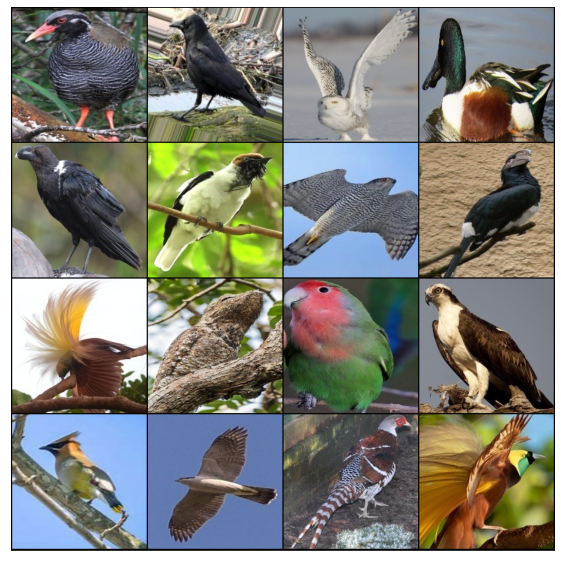

In [15]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

# Build Model

## Pseudocode

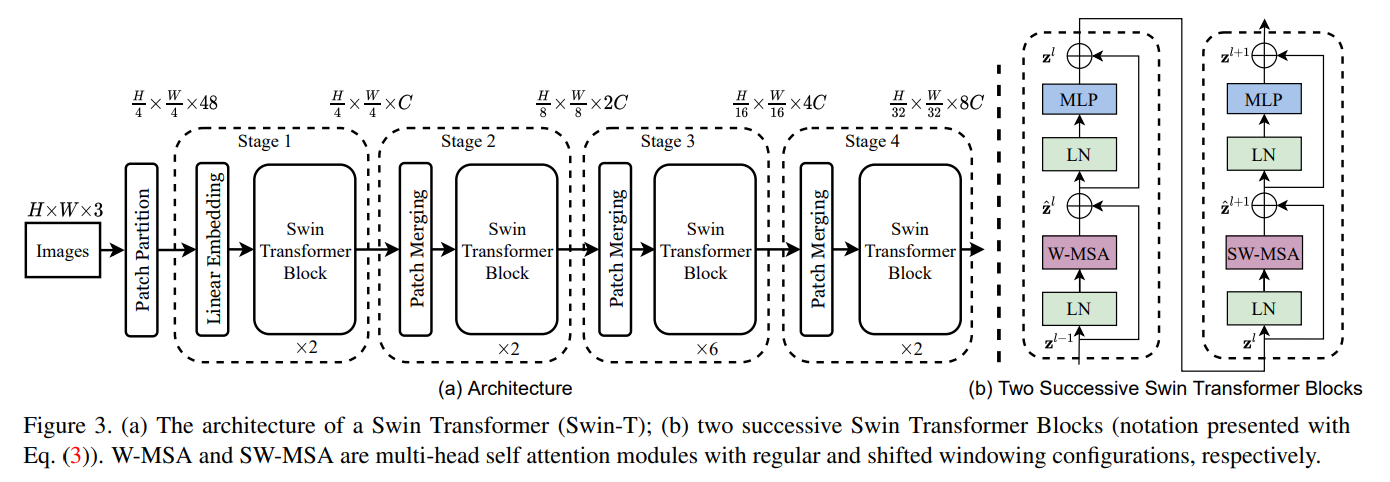

input image : (3,224,224)

patch size : 4

embedding size : 96



In [ ]:
'''
# Pre
1. input 들어감
2. 패치 파티션 
    * p_s : patch size
    - height/p_s = width/p_s = 56
    - [b,3,244,244] >> [b,3,56,56,4,4]
3. 패치당 96차원으로 프로젝션
    - [3,56,56,4,4] >> [96,56,56] >> [56*56,96] # 56*56개 패치는 96차원 임베딩 된거

Stage1
1. 트랜스포머 블럭으로들어감
    * LN : Layer Norm
  (0) x = inputs  [b,56*56,96]
  (1) x = x + W-MSA(LN(x.view(B,H,W,C))) 
    - LN(x.view(B,H,W,C)) [b,56*56,96]->[b,56,56,96]
    - Window partition.permute.view(B,w_s,w_s,c).view(-1,w_s,w_s) [b,56,56,96]-> [b,8,7,8,7,96] -> [b*8*8,7,7,96] -> [b*8*8,7*7,96] # 윈도우자채를 배치로 놓음
    - Attention!
    - Window reverse  [b*8*8,7*7,96] -> [b,56,56,96]
  (2) x = x + MLP(LN(x)) # FFN
  (3) x = x + SW-MSA(LN(x))
    * shift_size = window_size//2
    - cyclic shift
    - 이하 W-MSA와 동일
  (4) x = x + MLP(LN(x)) # FFN

Stage2~4
1. Patch Merging : 해상도 반(1/4)으로 줄이면서 머징함. 그러면 차원이 계속 늘어나니까 반씩 줄여줌
    - [b,56,56,96] -> [b,56//2,56//2,96*2]
2. 트랜스포머 블럭으로들어감

Let's move on
'''

## Pre

### Patch Partition + Linear Embedding

In [62]:

class PatchEmbedding(nn.Module):
  def __init__(self, image_size=224, in_channel=3, patch_size=4, embed=96):
    '''
    1. Patch Partition 
      * p_s : patch size
      - height/p_s = width/p_s = 56
      - [b,3,244,244] >> [b,56,56,3,4,4]
    2. Linear Embedding
      - [b,56,56,3,,4,4] >> [b,56,56,3] >> [b,56*56,96] # 56*56개 패치는 96차원 임베딩 된거
    '''
    super().__init__()
    self.in_channel = in_channel
    self.patch_size = patch_size
    self.n_patch = image_size//patch_size
    self.linear_embedding = nn.Linear(in_channel*patch_size*patch_size, embed)

  def forward(self,x):
    # patch _partition
    x = self.extract_patches(x) 
    # Linear Embedding
    print(x.shape)
    x = x.flatten(3)
    print(x.shape)
    x = self.linear_embedding(x)
    return x

  def extract_patches(self, img):
    # input image : B, C, H, W
    patch_fold_H = img.unfold(2,self.patch_size,self.patch_size)  # patch_fold_H : (B, C, H/Patchsize, W, Patchsize_H)
    patches = patch_fold_H.unfold(3, self.patch_size,self.patch_size) # patch_fold_H : (B, C, H/Patchsize(N_H), W/Patchsize(N_W), Patchsize_H, Patchsize_W)
    patches = patches.permute(0, 2, 3, 1, 4, 5) # patches : (B, C, N_H, N_W, Patchsize_H, Patchsize_W)
    return patches


inputs = torch.rand((1,3,224,224))
PatchEmbedding()(inputs).shape

torch.Size([1, 56, 56, 3, 4, 4])
torch.Size([1, 56, 56, 48])


torch.Size([1, 56, 56, 96])

## Swin Transformer Block

In [ ]:
class SwinTransformerBlock(nn.Module):
  def __init__(self, emb_dim=96,mlp_exp=4, window_size=7):
    """
    (0) x = inputs  [b,56*56,96]
    (1) x = x + W-MSA(LN(x.view(B,H,W,C))) 
    (2) x = x + MLP(LN(x)) # FFN
    (3) x = x + SW-MSA(LN(x))
    (4) x = x + MLP(LN(x)) # FFN
    """
    super().__init__()
    self.emb_dim = emb_dim
    self.mlp_exp = mlp.exp
    self.window_size = window_size

    self.w_ln = nn.LayerNorm(emb_dim)
    self.w_msa = MSA('no_shift')
    self.w_mlp = MLP(emb_dim, emb_dim*mlp_exp)

    self.sw_ln = nn.LayerNorm(emb_dim)
    self.sw_msa = MSA('shift')
    self.sw_mlp = MLP(emb_dim, emb_dim*mlp_exp)

  def forward(self,x):
    """
    (0) x = inputs  [b,56*56,96]
    (1) x = x + W-MSA(LN(x.view(B,H,W,C))) 
      - LN(x.view(B,H,W,C)) [b,56*56,96]->[b,56,56,96]
      - Window partition.permute.view(B,w_s,w_s,c).view(-1,w_s,w_s) [b,56,56,96]-> [b,8,7,8,7,96] -> [b*8*8,7,7,96] -> [b*8*8,7*7,96] # 윈도우자채를 배치로 놓음
      - Attention!
      - Window reverse  [b*8*8,7*7,96] -> [b,56,56,96]
    (2) x = x + MLP(LN(x)) # FFN
    (3) x = x + SW-MSA(LN(x))
      * shift_size = window_size//2
      - cyclic shift
      - 이하 W-MSA와 동일
    (4) x = x + MLP(LN(x)) # FFN
    """
    inputs = inputs 
    res = x # [b,56,56,96]
    x = self.w_ln(x)
    x = self.window_partition(x)
    x = res + self.w_msa()


  def window_partition(self,x):
    return x

  def cyclic_shift(self, x):
    return x


### Patch Merging

### W-MSA

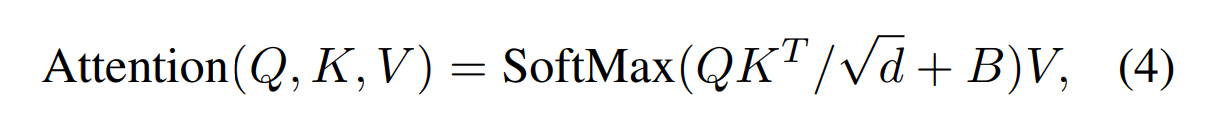

Relative position bias In computing self-attention, we
follow [49, 1, 32, 33] by including a relative position bias
B ∈ RM2×M2
to each head in computing similarity:
where Q, K, V ∈ RM2×d
are the query, key and value matrices; d is the query/key dimension, and M2
is the number
of patches in a window. Since the relative position along
each axis lies in the range [−M + 1, M −1], we parameterize a smaller-sized bias matrix Bˆ ∈ R
(2M−1)×(2M−1), and
values in B are taken from Bˆ.

We observe significant improvements over counterparts
without this bias term or that use absolute position embedding, as shown in Table 4. Further adding absolute position embedding to the input as in [20] drops performance
slightly, thus it is not adopted in our implementation.

The learnt relative position bias in pre-training can be
also used to initialize a model for fine-tuning with a different window size through bi-cubic interpolation [20, 63].

In [ ]:
# Use relative position embedding instead of position embeddint(ViT)
# Self Attention in a local window
class MSA_Block(nn.Module):
  def __init__(self, window_size=7, shift_size=0):
    super().__init__()
    

### SW-MSA

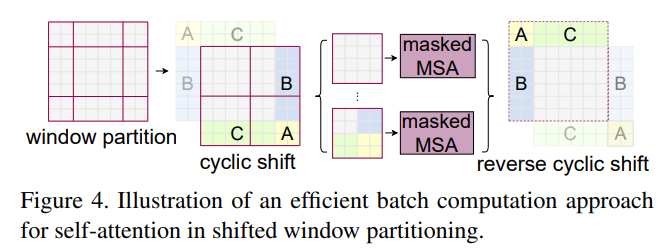

Here, we propose a more efficient batch computation approach by cyclic-shifting toward the top-left direction, as illustrated in Figure 4. After this shift, a batched window may
be composed of several sub-windows that are not adjacent
in the feature map, so a masking mechanism is employed to
limit self-attention computation to within each sub-window.
With the cyclic-shift, the number of batched windows remains the same as that of regular window partitioning, and
thus is also efficient.

In [16]:
224/4

56.0

In [ ]:
# Cyclic Shift
# Masking
# Reverse cyclic shift
# Self Attention between local windows 

### MLP

the expansion layer of each MLP is α = 4

In [ ]:
class MLP(nn.Module):
  def __init__(self,emb_size=768, mlp_size=3072, a=4, **kwargs):
    super().__init__()
    self.ln = nn.LayerNorm((emb_size))
    self.mlp_in = nn.Linear(emb_size, emb_size*a)
    self.gelu = nn.GELU()
    self.mlp_out = nn.Linear(emb_size*a, emb_size)
    
  def forward(self,inputs):
    inputs = self.ln(inputs)
    x = self.mlp_in(inputs)
    x = self.gelu(x)
    output = self.mlp_out(x)
    return output

### Swin Transformer Block

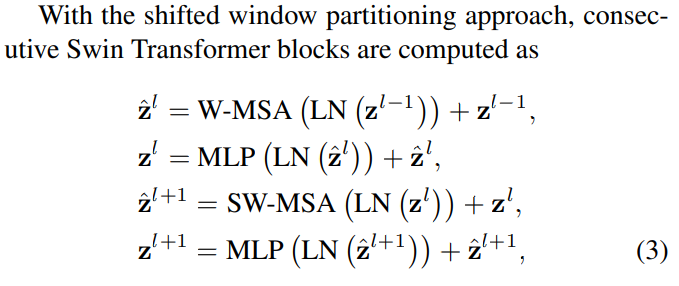

In [ ]:
# LN
# W-MSA
# LN
# MLP - GELU

# LN
# SW-MSA
# LN
# MLP - GELU

## Swin Transformer

We build our base model, called Swin-B, to have of
model size and computation complexity similar to ViTB/DeiT-B. We also introduce Swin-T, Swin-S and Swin-L,
which are versions of about 0.25×, 0.5× and 2× the model
size and computational complexity, respectively. Note that
the complexity of Swin-T and Swin-S are similar to those
of ResNet-50 (DeiT-S) and ResNet-101, respectively. The
window size is set to M = 7 by default. The query dimension of each head is d = 32, and the expansion layer of
each MLP is α = 4, for all experiments. The architecture
hyper-parameters of these model variants are:

• Swin-T: C = 96, layer numbers = {2, 2, 6, 2}

• Swin-S: C = 96, layer numbers ={2, 2, 18, 2}

• Swin-B: C = 128, layer numbers ={2, 2, 18, 2}

• Swin-L: C = 192, layer numbers ={2, 2, 18, 2}

where C is the channel number of the hidden layers in the
first stage.

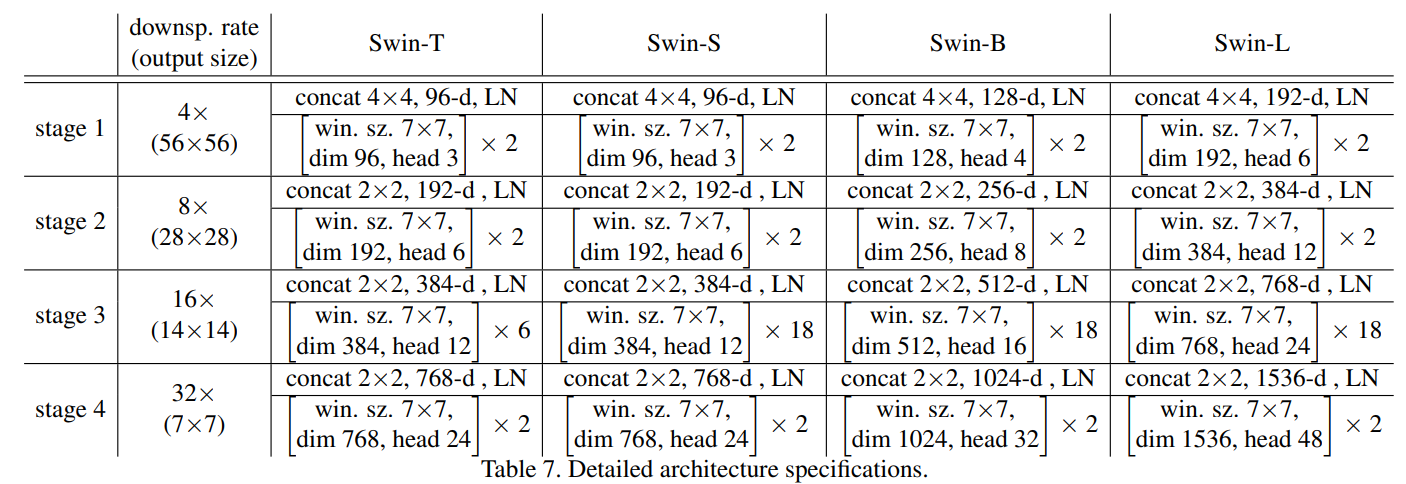

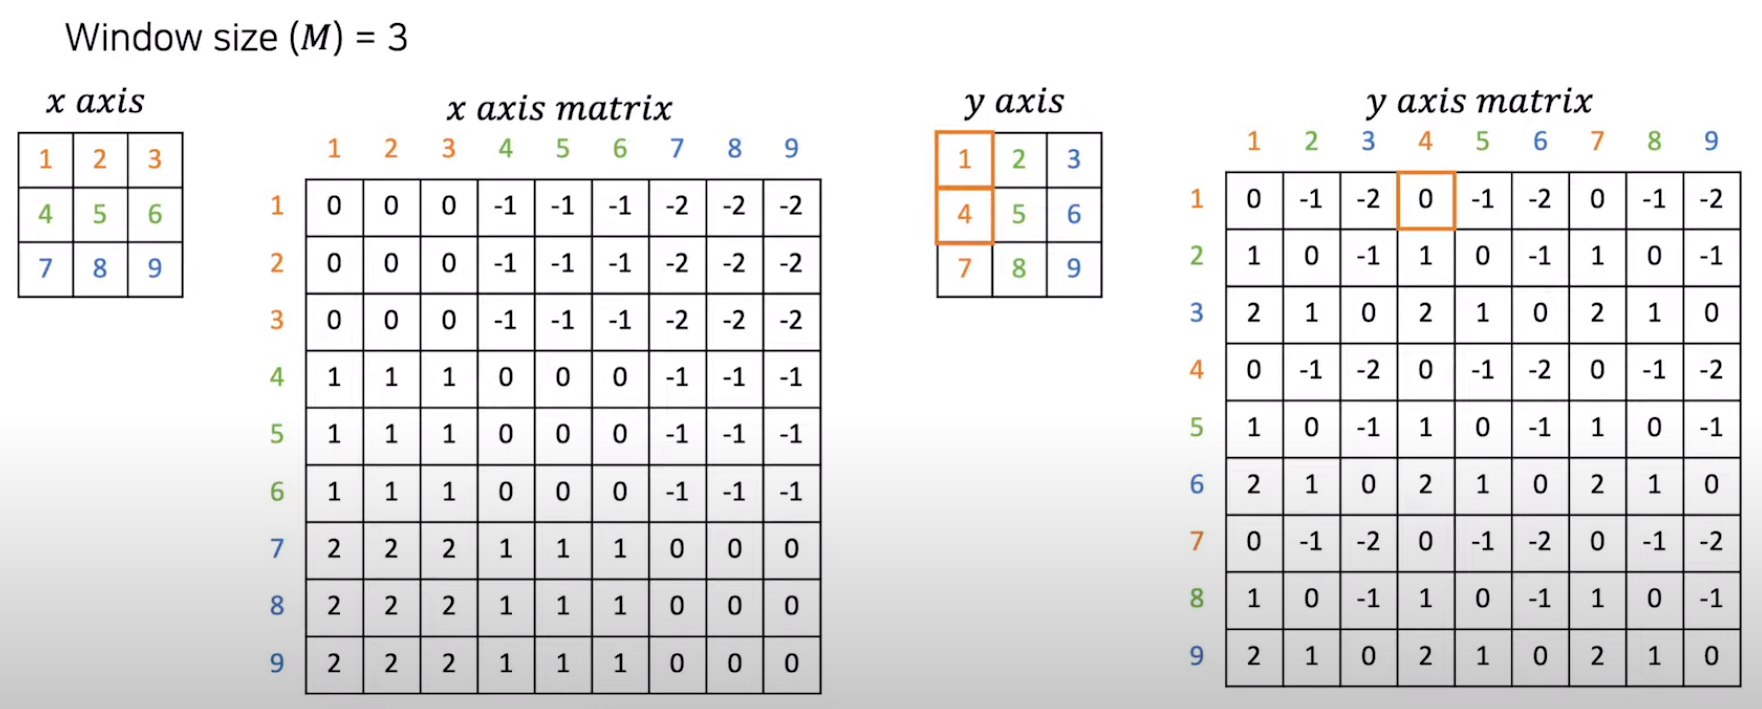

In [ ]:
# Efficient Batch Computation - 윈도우를 배치로 놔서 한번에 처리하는 기법
# Relative Position Bias - 포지션임베딩 안하고 편향으로 놓음